In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import xlabel,ylabel,title,subplots,show,text,plot

In [76]:
# Read in the data set
olympics = pd.read_csv('athlete_events.csv')
olympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [77]:
print(olympics.isnull().sum())

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64


In [78]:
olympics['Medal'].fillna('P', inplace = True)

In [79]:
print(olympics.isnull().sum())

ID            0
Name          0
Sex           0
Age        9474
Height    60171
Weight    62875
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport         0
Event         0
Medal         0
dtype: int64


In [80]:
print(olympics.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts().head())

FRA    160
USA     97
GBR     96
SWE     52
NOR     46
Name: NOC, dtype: int64


In [81]:
# Lets read in the noc_country mapping first
noc_country = pd.read_csv('noc_regions.csv')
noc_country.drop('notes', axis = 1 , inplace = True)
noc_country.rename(columns = {'region':'Country'}, inplace = True)

noc_country.head()

,NOC,Country
0,AFG,Afghanistan
1,AHO,Curacao
2,ALB,Albania
3,ALG,Algeria
4,AND,Andorra


In [82]:
# merging
olympics_merge = olympics.merge(noc_country,
                                left_on = 'NOC',
                                right_on = 'NOC',
                                how = 'left')

In [83]:
olympics_merge.loc[olympics_merge['Country'].isnull(),['NOC', 'Team']].drop_duplicates()

,NOC,Team
578,SGP,Singapore
6267,ROT,Refugee Olympic Athletes
44376,SGP,June Climene
61080,UNK,Unknown
64674,TUV,Tuvalu
80986,SGP,Rika II
108582,SGP,Singapore-2
235895,SGP,Singapore-1


In [84]:
# Replace missing Teams by the values above.
#olympics_merge.loc[olympics_merge['Country'].isnull(), ['Country']] = olympics_merge['Team']

olympics_merge['Country'] = np.where(olympics_merge['NOC']=='SGP', 'Singapore', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='ROT', 'Refugee Olympic Athletes', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='UNK', 'Unknown', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='TUV', 'Tuvalu', olympics_merge['Country'])


# Put these values from Country into Team
olympics_merge.drop('Team', axis = 1, inplace = True)
olympics_merge.rename(columns = {'Country': 'Team'}, inplace = True)

In [85]:
# Glance at the data.
w_gdp = pd.read_csv('world_gdp.csv', skiprows = 3)

# Remove unnecessary columns
w_gdp.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

# The columns are the years for which the GDP has been recorded. This needs to brought into a single column for efficient
# merging.
w_gdp = pd.melt(w_gdp, id_vars = ['Country Name', 'Country Code'], var_name = 'Year', value_name = 'GDP')

# convert the year column to numeric
w_gdp['Year'] = pd.to_numeric(w_gdp['Year'])

w_gdp.head()

,Country Name,Country Code,Year,GDP
0,Afghanistan,AFG,1960,5.377778e+08
1,Albania,ALB,1960,NaN
2,Algeria,DZA,1960,2.723649e+09
3,American Samoa,ASM,1960,NaN
4,Andorra,AND,1960,NaN


In [86]:
len(list(set(olympics_merge['NOC'].unique()) - set(w_gdp['Country Code'].unique())))

108

In [87]:
len(list(set(olympics_merge['Team'].unique()) - set(w_gdp['Country Name'].unique())))

6

In [88]:
# Merge to get country code
olympics_merge_ccode = olympics_merge.merge(w_gdp[['Country Name', 'Country Code']].drop_duplicates(),
                                            left_on = 'Team',
                                            right_on = 'Country Name',
                                            how = 'left')

olympics_merge_ccode.drop('Country Name', axis = 1, inplace = True)

# Merge to get gdp too
olympics_merge_gdp = olympics_merge_ccode.merge(w_gdp,
                                                left_on = ['Country Code', 'Year'],
                                                right_on = ['Country Code', 'Year'],
                                                how = 'left')

olympics_merge_gdp.drop('Country Name', axis = 1, inplace = True)

In [89]:
# Read in the population data
w_pop = pd.read_csv('world_pop.csv')

w_pop.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

w_pop = pd.melt(w_pop, id_vars = ['Country', 'Country Code'], var_name = 'Year', value_name = 'Population')

# Change the Year to integer type
w_pop['Year'] = pd.to_numeric(w_pop['Year'])

w_pop.head()

,Country,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0


In [90]:
olympics_complete = olympics_merge_gdp.merge(w_pop,
                                            left_on = ['Country Code', 'Year'],
                                            right_on= ['Country Code', 'Year'],
                                            how = 'left')

olympics_complete.drop('Country', axis = 1, inplace = True)

olympics_complete.head()

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Team,Country Code,GDP,Population
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,P,China,CHN,4.269160e+11,1.164970e+09
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,P,China,CHN,8.560550e+12,1.350695e+09
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,P,Denmark,DNK,NaN,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,DNK,NaN,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,P,Netherlands,NLD,2.585680e+11,1.476009e+07


In [91]:
olympics_complete.isnull().sum()

ID                  0
Name                0
Sex                 0
Age              9474
Height          60171
Weight          62875
NOC                 0
Games               0
Year                0
Season              0
City                0
Sport               0
Event               0
Medal               0
Team                0
Country Code     1397
GDP             86925
Population      65120
dtype: int64

In [92]:
# Lets take data from 1961 onwards only and for summer olympics only
olympics_complete_subset = olympics_complete.loc[(olympics_complete['Year'] > 1960) & (olympics_complete['Season'] == "Summer"), :]

# Reset row indices
olympics_complete_subset = olympics_complete_subset.reset_index()

In [93]:
olympics_complete_subset['Medal_Won'] = np.where(olympics_complete_subset.loc[:,'Medal'] == 'P', 0, 1)

In [94]:
# Check whether number of medals won in a year for an event by a team exceeds 1. This indicates a team event.
identify_team_events = pd.pivot_table(olympics_complete_subset,
                                      index = ['Team', 'Year', 'Event'],
                                      columns = 'Medal',
                                      values = 'Medal_Won',
                                      aggfunc = 'sum',
                                     fill_value = 0).drop('P', axis = 1).reset_index()

identify_team_events = identify_team_events.loc[identify_team_events['Gold'] > 1, :]

team_sports = identify_team_events['Event'].unique()

In [95]:
# if an event name matches with one in team sports, then it is a team event. Others are singles events.
team_event_mask = olympics_complete_subset['Event'].map(lambda x: x in team_sports)
single_event_mask = [not i for i in team_event_mask]

# rows where medal_won is 1
medal_mask = olympics_complete_subset['Medal_Won'] == 1

# Put 1 under team event if medal is won and event in team event list
olympics_complete_subset['Team_Event'] = np.where(team_event_mask & medal_mask, 1, 0)

# Put 1 under singles event if medal is won and event not in team event list
olympics_complete_subset['Single_Event'] = np.where(single_event_mask & medal_mask, 1, 0)

# Add an identifier for team/single event
olympics_complete_subset['Event_Category'] = olympics_complete_subset['Single_Event'] + \
olympics_complete_subset['Team_Event']

In [96]:
medal_tally_agnostic = olympics_complete_subset.\
groupby(['Year', 'Team', 'Event', 'Medal'])[['Medal_Won', 'Event_Category']].\
agg('sum').reset_index()

medal_tally_agnostic['Medal_Won_Corrected'] = medal_tally_agnostic['Medal_Won']/medal_tally_agnostic['Event_Category']

In [97]:
# Medal Tally.
medal_tally = medal_tally_agnostic.groupby(['Year','Team'])['Medal_Won_Corrected'].agg('sum').reset_index()

medal_tally_pivot = pd.pivot_table(medal_tally,
                     index = 'Team',
                     columns = 'Year',
                     values = 'Medal_Won_Corrected',
                     aggfunc = 'sum',
                     margins = True).sort_values('All', ascending = False)[1:5]

# print total medals won in the given period
medal_tally_pivot.loc[:,'All']

Team
USA        1387.0
Russia     1298.0
Germany    1042.0
China       545.0
Name: All, dtype: float64

Text(0.5, 1.0, 'Olympic Performance Comparison')

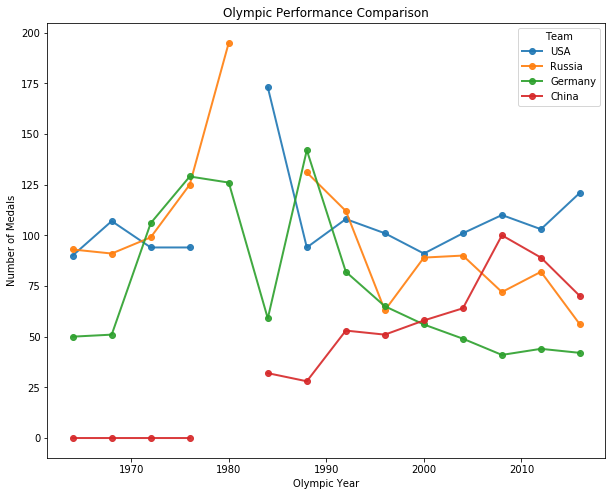

In [98]:
# List of top countries
top_countries = ['USA', 'Russia', 'Germany', 'China']

year_team_medals = pd.pivot_table(medal_tally,
                                  index = 'Year',
                                  columns = 'Team',
                                  values = 'Medal_Won_Corrected',
                                  aggfunc = 'sum')[top_countries]

# plotting the medal tallies
year_team_medals.plot(linestyle = '-', marker = 'o', alpha = 0.9, figsize = (10,8), linewidth = 2)
xlabel('Olympic Year')
ylabel('Number of Medals')
title('Olympic Performance Comparison')

Text(0, 0.5, 'Number of Medals')

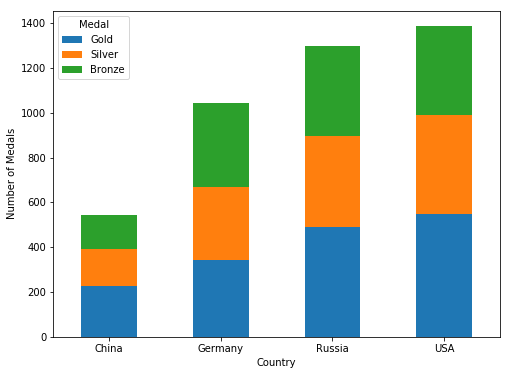

In [107]:
# List of top countries
top_countries = ['USA', 'Russia', 'Germany', 'China']

# row mask where countries match
row_mask_2 = medal_tally_agnostic['Team'].map(lambda x: x in top_countries)

# Pivot table to calculate sum of gold, silver and bronze medals for each country
medal_tally_specific = pd.pivot_table(medal_tally_agnostic[row_mask_2],
                                     index = ['Team'],
                                     columns = 'Medal',
                                     values = 'Medal_Won_Corrected',
                                     aggfunc = 'sum',
                                     fill_value = 0).drop('P', axis = 1)

# Re-order the columns so that they appear in order on the chart.
medal_tally_specific = medal_tally_specific.loc[:, ['Gold', 'Silver', 'Bronze']]

medal_tally_specific.plot(kind = 'bar', stacked = True, figsize = (8,6), rot = 0)
xlabel('Country')
ylabel('Number of Medals')

In [100]:
# To get the sports, teams are best at, we now aggregate the medal_tally_agnostic dataframe as we did earlier.
best_team_sports = pd.pivot_table(medal_tally_agnostic[row_mask_2],
                                  index = ['Team', 'Event'],
                                  columns = 'Medal',
                                  values = 'Medal_Won_Corrected',
                                  aggfunc = 'sum',
                                  fill_value = 0).sort_values(['Team', 'Gold'], ascending = [True, False]).reset_index()

best_team_sports.drop(['Bronze', 'Silver', 'P'], axis = 1, inplace = True)
best_team_sports.columns = ['Team', 'Event', 'Gold_Medal_Count']

best_team_sports.groupby('Team').head(5)

,Team,Event,Gold_Medal_Count
0,China,Diving Women's Springboard,8
1,China,Table Tennis Women's Singles,8
2,China,Diving Women's Platform,7
3,China,Weightlifting Men's Lightweight,6
4,China,Badminton Women's Doubles,5
343,Germany,"Equestrianism Mixed Dressage, Team",11
344,Germany,"Canoeing Women's Kayak Doubles, 500 metres",7
345,Germany,Rowing Men's Quadruple Sculls,7
346,Germany,Rowing Women's Quadruple Sculls,6
347,Germany,Athletics Men's Discus Throw,5


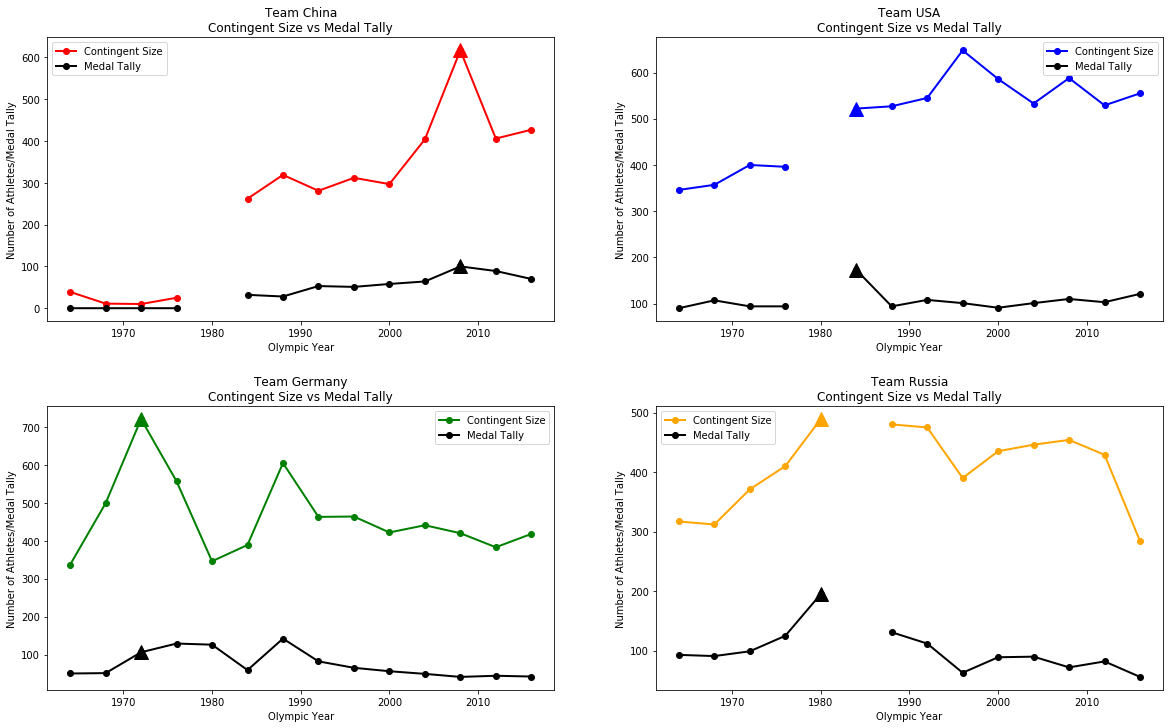

In [101]:
row_mask_3 = olympics_complete_subset['Team'].map(lambda x: x in top_countries)

# Get year wise team wise athletes.
year_team_athelete = olympics_complete_subset.loc[row_mask_3, ['Year','Team', 'Name']].drop_duplicates()

# sum these up to get total contingent size.
contingent_size = pd.pivot_table(year_team_athelete,
                                 index = 'Year',
                                 columns = 'Team',
                                 values = 'Name',
                                 aggfunc = 'count')

fig, ((ax1, ax2), (ax3, ax4)) = subplots(nrows = 2,
                                         ncols = 2,
                                        figsize = (20,12))

fig.subplots_adjust(hspace = 0.3)

# Plot australia's medal tally and contingent size
contingent_size['China'].plot(ax = ax1, linestyle = '-', marker = 'o', linewidth = 2, color = 'red', 
                                  label = 'Contingent Size')
year_team_medals['China'].plot(ax = ax1, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                                  label = 'Medal Tally')
ax1.plot(2008, contingent_size.loc[2008, 'China'], marker = '^', color = 'red', ms = 14)
ax1.plot(2008, year_team_medals.loc[2008, 'China'], marker = '^', color = 'black', ms = 14)
ax1.set_xlabel('Olympic Year')
ax1.set_ylabel('Number of Athletes/Medal Tally')
ax1.set_title('Team China\nContingent Size vs Medal Tally')
ax1.legend(loc = 'best')

# Plot USA's medal tally and contingent size
contingent_size['USA'].plot(ax = ax2, linestyle = '-', marker = 'o', linewidth = 2, color = 'blue',
                           label = 'Contingent Size')
year_team_medals['USA'].plot(ax = ax2, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                            label = 'Medal Tally')
ax2.plot(1984, contingent_size.loc[1984, 'USA'], marker = '^', color = 'blue', ms = 14)
ax2.plot(1984, year_team_medals.loc[1984, 'USA'], marker = '^', color = 'black', ms = 14)
ax2.set_xlabel('Olympic Year')
ax2.set_ylabel('Number of Athletes/Medal Tally')
ax2.set_title('Team USA\nContingent Size vs Medal Tally')
ax2.legend(loc = 'best')

# Plot Germany's medal tally and contingent size
contingent_size['Germany'].plot(ax = ax3, linestyle = '-', marker = 'o', linewidth = 2, color = 'green',
                               label = 'Contingent Size')
year_team_medals['Germany'].plot(ax = ax3, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                                label = 'Medal Tally')
ax3.plot(1972, year_team_medals.loc[1972, 'Germany'], marker = '^', color = 'black', ms = 14)
ax3.plot(1972, contingent_size.loc[1972, 'Germany'], marker = '^', color = 'green', ms = 14)
ax3.set_xlabel('Olympic Year')
ax3.set_ylabel('Number of Athletes/Medal Tally')
ax3.set_title('Team Germany\nContingent Size vs Medal Tally')
ax3.legend(loc = 'best')

# Plot Russia's medal tally and contingent size
contingent_size['Russia'].plot(ax = ax4, linestyle = '-', marker = 'o', linewidth = 2, color = 'orange',
                              label = 'Contingent Size')
year_team_medals['Russia'].plot(ax = ax4, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                               label = 'Medal Tally')
ax4.plot(1980, contingent_size.loc[1980, 'Russia'], marker = '^', color = 'orange', ms = 14)
ax4.plot(1980, year_team_medals.loc[1980, 'Russia'], marker = '^', color = 'black', ms = 14)
ax4.set_xlabel('Olympic Year')
ax4.set_ylabel('Number of Athletes/Medal Tally')
ax4.set_title('Team Russia\nContingent Size vs Medal Tally')
ax4.legend(loc = 'best')

show()

In [102]:
# Lets merge contingent size and medals won!
year_team_medals_unstack = year_team_medals.unstack().reset_index()
year_team_medals_unstack.columns = ['Team','Year', 'Medal_Count']

contingent_size_unstack = contingent_size.unstack().reset_index()

contingent_size_unstack.columns = ['Team','Year', 'Contingent']

contingent_medals = contingent_size_unstack.merge(year_team_medals_unstack,
                                                 left_on = ['Team', 'Year'],
                                                 right_on = ['Team', 'Year'])

contingent_medals[['Contingent', 'Medal_Count']].corr()



,Contingent,Medal_Count
Contingent,1.000000,0.703625
Medal_Count,0.703625,1.000000


In [103]:
# merge best team sports with olympics data to get sport for each event.
team_commonalities = best_team_sports.merge(olympics_complete_subset.loc[:,['Sport', 'Event']].drop_duplicates(),
                                           left_on = 'Event',
                                           right_on = 'Event')

team_commonalities = team_commonalities.sort_values(['Team', 'Gold_Medal_Count'], ascending = [True, False])
team_commonalities = team_commonalities.groupby('Team').head(5).reset_index()

# make a pivot table of the commonalities.
pd.pivot_table(team_commonalities,
              index = 'Sport',
              columns = 'Team',
              values = 'Event',
              aggfunc = 'count',
              fill_value = 0,
              margins = True).sort_values('All', ascending = False)[1:]

Team,China,Germany,Russia,USA,All
Sport,,,,,
Athletics,0,1,0,2,3
Diving,2,0,0,0,2
Rowing,0,2,0,0,2
Swimming,0,0,0,2,2
Wrestling,0,0,2,0,2
Badminton,1,0,0,0,1
Basketball,0,0,0,1,1
Canoeing,0,1,0,0,1
Equestrianism,0,1,0,0,1


In [104]:
olympics_complete_subset[['Year', 'City']].drop_duplicates().sort_values('Year')

,Year,City
74,1964,Tokyo
11,1968,Mexico City
12,1972,Munich
37,1976,Montreal
70,1980,Moskva
10,1984,Los Angeles
13,1988,Seoul
0,1992,Barcelona
3,1996,Atlanta
2,2000,Sydney


In [105]:
# Correct city names in the dataset
olympics_complete_subset['City'].replace(['Athina', 'Moskva'], ['Athens', 'Moscow'], inplace = True)

# city to country mapping dictionary
city_to_country = {'Tokyo': 'Japan',
                  'Mexico City': 'Mexico',
                  'Munich': 'Germany',
                  'Montreal': 'Canada',
                  'Moscow': 'Russia',
                  'Los Angeles': 'USA',
                  'Seoul': 'South Korea',
                  'Barcelona': 'Spain',
                  'Atlanta': 'USA',
                  'Sydney': 'Australia',
                  'Athens': 'Greece',
                  'Beijing': 'China',
                  'London': 'UK',
                  'Rio de Janeiro': 'Brazil'}

# Map cities to countries
olympics_complete_subset['Country_Host'] = olympics_complete_subset['City'].map(city_to_country)

#print the 
olympics_complete_subset.loc[:, ['Year', 'Country_Host']].drop_duplicates().sort_values('Year')

# Extract year, host nation and team name from the data
year_host_team = olympics_complete_subset[['Year', 'Country_Host', 'Team']].drop_duplicates()

# check rows where host country is the same as team
row_mask_4 = (year_host_team['Country_Host'] == year_host_team['Team'])

# add years in the year_host_team to capture one previous and one later year
year_host_team['Prev_Year'] = year_host_team['Year'] - 4
year_host_team['Next_Year'] = year_host_team['Year'] + 4

# Subset only where host nation and team were the same
year_host_team = year_host_team[row_mask_4]

# Calculate the medals won in each year where a team played at home. merge year_host_team with medal_tally on year and team
year_host_team_medal = year_host_team.merge(medal_tally,
                                           left_on = ['Year', 'Team'],
                                           right_on = ['Year', 'Team'],
                                           how = 'left')

year_host_team_medal.rename(columns = {'Medal_Won_Corrected' : 'Medal_Won_Host_Year'}, inplace = True)

# Calculate medals won by team in previous year
year_host_team_medal = year_host_team_medal.merge(medal_tally,
                                                 left_on = ['Prev_Year', 'Team'],
                                                 right_on = ['Year', 'Team'],
                                                 how = 'left')

year_host_team_medal.drop('Year_y', axis = 1, inplace = True)
year_host_team_medal.rename(columns = {'Medal_Won_Corrected': 'Medal_Won_Prev_Year',
                                      'Year_x':'Year'}, inplace = True)

# Calculate the medals won by the team the year after they hosted.
year_host_team_medal = year_host_team_medal.merge(medal_tally,
                                                 left_on = ['Next_Year', 'Team'],
                                                 right_on = ['Year', 'Team'],
                                                 how = 'left')

year_host_team_medal.drop('Year_y', axis = 1, inplace = True)
year_host_team_medal.rename(columns = {'Year_x': 'Year',
                                      'Medal_Won_Corrected' : 'Medal_Won_Next_Year'}, inplace = True)

# General formatting changes
year_host_team_medal.drop(['Prev_Year', 'Next_Year'], axis = 1, inplace = True)
year_host_team_medal.sort_values('Year', ascending = True, inplace = True)
year_host_team_medal.reset_index(inplace = True, drop = True)

# column re-ordering
year_host_team_medal = year_host_team_medal.loc[:, ['Year', 'Country_Host', 'Team', 'Medal_Won_Prev_Year', 'Medal_Won_Host_Year', 'Medal_Won_Next_Year']]

year_host_team_medal

,Year,Country_Host,Team,Medal_Won_Prev_Year,Medal_Won_Host_Year,Medal_Won_Next_Year
0,1964,Japan,Japan,NaN,29.0,25.0
1,1968,Mexico,Mexico,1.0,9.0,1.0
2,1972,Germany,Germany,51.0,106.0,129.0
3,1976,Canada,Canada,5.0,11.0,NaN
4,1980,Russia,Russia,125.0,195.0,NaN
5,1984,USA,USA,NaN,173.0,94.0
6,1988,South Korea,South Korea,19.0,33.0,28.0
7,1992,Spain,Spain,4.0,22.0,17.0
8,1996,USA,USA,108.0,101.0,91.0
9,2000,Australia,Australia,41.0,58.0,50.0


Text(7101223999999.844, 145.0, 'Correlation = 0.622903299762292')

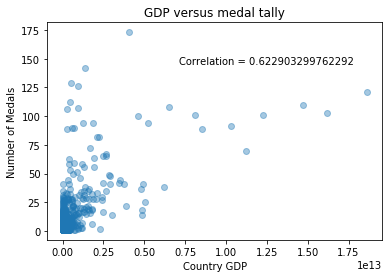

In [111]:
year_team_gdp = olympics_complete_subset.loc[:, ['Year', 'Team', 'GDP']].drop_duplicates()

medal_tally_gdp = medal_tally.merge(year_team_gdp,
                                   left_on = ['Year', 'Team'],
                                   right_on = ['Year', 'Team'],
                                   how = 'left')

row_mask_5 = medal_tally_gdp['Medal_Won_Corrected'] > 0
row_mask_6 = medal_tally_gdp['Team'].map(lambda x: x in top_countries)

correlation = medal_tally_gdp.loc[row_mask_5, ['GDP', 'Medal_Won_Corrected']].corr()['Medal_Won_Corrected'][0]

plot(medal_tally_gdp.loc[row_mask_5, 'GDP'], 
     medal_tally_gdp.loc[row_mask_5, 'Medal_Won_Corrected'] , 
     linestyle = 'none', 
     marker = 'o',
    alpha = 0.4)
xlabel('Country GDP')

ylabel('Number of Medals')
title('GDP versus medal tally')
text(np.nanpercentile(medal_tally_gdp['GDP'], 99.6), 
     max(medal_tally_gdp['Medal_Won_Corrected']) - 50,
     "Correlation = " + str(correlation))

Text(1182602944.4879928, 145.0, 'Correlation = 0.3023032003793292')

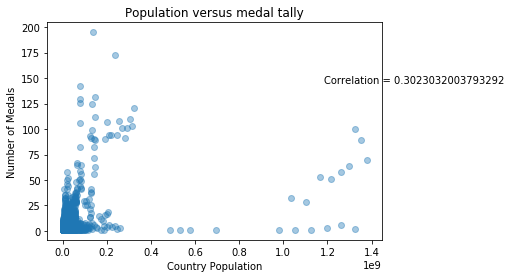

In [112]:
year_team_pop = olympics_complete_subset.loc[:, ['Year', 'Team', 'Population']].drop_duplicates()

medal_tally_pop = medal_tally.merge(year_team_pop,
                                   left_on = ['Year', 'Team'],
                                   right_on = ['Year', 'Team'],
                                   how = 'left')

row_mask_5 = medal_tally_pop['Medal_Won_Corrected'] > 0
row_mask_6 = medal_tally_pop['Team'].map(lambda x: x in top_countries)

correlation = medal_tally_pop.loc[row_mask_5, ['Population', 'Medal_Won_Corrected']].corr()['Medal_Won_Corrected'][0]

plot(medal_tally_pop.loc[row_mask_5, 'Population'], 
     medal_tally_pop.loc[row_mask_5, 'Medal_Won_Corrected'] , 
     linestyle = 'none', 
     marker = 'o',
    alpha = 0.4)
xlabel('Country Population')

ylabel('Number of Medals')
title('Population versus medal tally')
text(np.nanpercentile(medal_tally_pop['Population'], 99.6), 
     max(medal_tally_pop['Medal_Won_Corrected']) - 50,
     "Correlation = " + str(correlation))

In [122]:
year_team_gdp_pop = olympics_complete_subset.loc[:, ['Year','Team','GDP','Population']].drop_duplicates()

medal_gdp_pop = medal_tally.merge(year_team_gdp_pop,
                                   left_on = ['Year', 'Team'],
                                   right_on = ['Year', 'Team'],
                                   how = 'left')
medal_gdp_pop = medal_gdp_pop.dropna()
medal_gdp_pop.head(100)

,Year,Team,Medal_Won_Corrected,GDP,Population
0,1964,Afghanistan,0.0,8.000000e+08,9731361.0
1,1964,Algeria,0.0,2.909352e+09,12295970.0
2,1964,Argentina,1.0,2.560525e+10,21953929.0
3,1964,Australia,18.0,2.378766e+10,11167000.0
4,1964,Austria,0.0,9.169984e+09,7223801.0
5,1964,Bahamas,1.0,2.666667e+08,133698.0
6,1964,Belgium,3.0,1.596011e+10,9378113.0
7,1964,Bermuda,0.0,1.075667e+08,48900.0
9,1964,Brazil,1.0,2.121189e+10,81168654.0
11,1964,Cambodia,0.0,7.828571e+08,6331583.0


In [124]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
year_team_gender = olympics_complete_subset[['Year','Team', 'Name', 'Sex']].drop_duplicates()
contingent_size = pd.pivot_table(year_team_gender,
                                 index = ['Year','Team'],
                                 columns = 'Sex',
                                 aggfunc = 'count').reset_index()
# rename columns as per column names in the 0th level
contingent_size.columns = contingent_size.columns.get_level_values(0)

# rename the columns appropriately
contingent_size.columns = ['Year', 'Team', 'Female_Athletes', 'Male_Athletes']

contingent_size['Total_Athletes'] = contingent_size['Female_Athletes'] + \
contingent_size['Male_Athletes']
#medal_all = medal_all.drop(medal_all[medal_all.Medal_Count == 0].index)
contingent_size = contingent_size.dropna()
contingent_size = contingent_size.drop(['Female_Athletes','Male_Athletes'],axis=1)
contingent_size.head(100)

medal_all = contingent_size.merge(medal_gdp_pop,
                                   left_on = ['Year', 'Team'],
                                   right_on = ['Year', 'Team'],
                                   )
X = medal_all[['Total_Athletes','GDP','Population']]

y = medal_all['Medal_Won_Corrected']

X = X.values

y=y.values

X_Train,X_Test,Y_Train,Y_Test = train_test_split(X,y,test_size=0.2,random_state=1)

lm = linear_model.LinearRegression()
lreg = lm.fit(X_Train,Y_Train)
print("Linear model for GDP,Population, and Medal Tally:")
print("linear model intercept b = ",lreg.intercept_)
print("linear model coefficient w = ",lreg.coef_)
print("Training:",lreg.score(X_Train,Y_Train))
print("Test:",lreg.score(X_Test,Y_Test))



Linear model for GDP,Population, and Medal Tally:
linear model intercept b =  -2.560586705500689
linear model coefficient w =  [1.15552710e-01 2.48507668e-12 3.34236795e-09]
Training: 0.7660728420640506
Test: 0.7720269718421335


In [129]:
test = [[550,22034000000000,334500000]]
medal_predict = lm.predict(test)
print("The predicted number of medals for US contingent in Summer 2020 olympics is: ",medal_predict)

The predicted number of medals for US contingent in Summer 2020 olympics is:  [116.86760563]


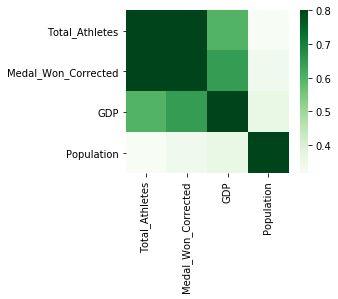

In [132]:
import seaborn as sns
#medal_all = medal_all.drop(['Year'],axis=1)
matrix = medal_all.corr()
f, ax = plt.subplots(figsize=(4, 3)) 
sns.heatmap(matrix, vmax=.8, square=True, cmap="Greens");

In [ ]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=5)
k_data = medal_gdp_pop.drop(columns=['Year','Team','Population'])

model.fit(k_data)
y_predict = model.predict(k_data)
plt.scatter(k_data['GDP'], k_data['Medal_Won_Corrected'], c=y_predict, s=50, cmap='viridis')



In [ ]:
from sklearn.neighbors import KNeighborsClassifier  

medal_gdp_pop = medal_gdp_pop.drop(medal_gdp_pop[medal_gdp_pop.Medal_Won_Corrected == 0].index)

X = medal_gdp_pop['GDP']

y = medal_gdp_pop['Medal_Won_Corrected']

X = X.values

y=y.values

X_Train,X_Test,Y_Train,Y_Test = train_test_split(X,y,random_state=0)

X_Train = X_Train.reshape(-1,1)
# print(type(X_Train))
X_Test = X_Test.reshape(-1,1)

from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_Train)

X_Train = scaler.transform(X_Train)  
X_Test = scaler.transform(X_Test)

classifier = KNeighborsClassifier(n_neighbors=3)  
classifier.fit(X_Train, Y_Train)  

y_pred = classifier.predict(X_Test)

from sklearn import metrics

print(metrics.accuracy_score(Y_Test, y_pred))